# Predicting Bulldozer Sales Price using Machine Learning Regression 


In this notebook we are going to go through an example machine learning project with the goal of predicting  the sales prices of bulldozers

![](./images/6-step-ml-framework.png)

# 1. Problem Definition

> How well can we predict the futuresales price of a bulldozer, given its characteristics and previous exapmles of how much similar bulldozers have been sold for.

# 2. Data

- The data is downloaded from the Kaggle's Bluebook for Bulldozer's competition:
    * There are three main datasets:

        * Train.csv is the training set, which contains data through the end of 2011.
    
        * Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
    
        * Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

# 3. Evaluation

> The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more information on the evaluation for this project, check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimizes RMSLE.

# 4. Features

This is the data dictionary provided by Kaggle:
https://docs.google.com/spreadsheets/d/1_EHdNhxqe-WaeVti794-USi0Mtdg6y84GA5Uj4OaIkg/edit?usp=sharing

This is a google sheets link.

# 0. Standard Imports

In [1]:
# data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR, LinearSVR

# evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split

# experimentation
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# 2. Data

Used libraries:-
1. Pandas
2. NumPy
3. Matplotlib
4. Seaborn

In [2]:
df = pd.read_csv('data/TrainAndValid.csv',
                 low_memory=False)
df.size

21872994

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

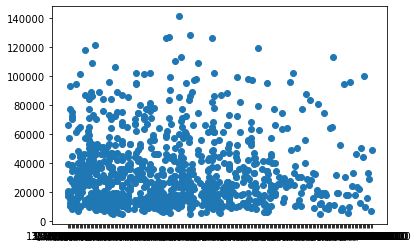

In [5]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

<AxesSubplot:ylabel='Frequency'>

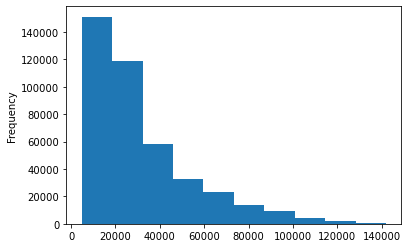

In [6]:
df['SalePrice'].plot.hist()

### Parsing dates

When working with time series data, we want to enrich the time and date component as much as possible

We can do that by using pandas to indentify the date column using the `parse_date` parameter

In [7]:
# Import data while parsing dates

data = pd.read_csv('data/TrainAndValid.csv',
                   low_memory=False,
                   parse_dates=['saledate'])


In [8]:
data['saledate'].dtype

dtype('<M8[ns]')

In [9]:
data.saledate[:10]

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

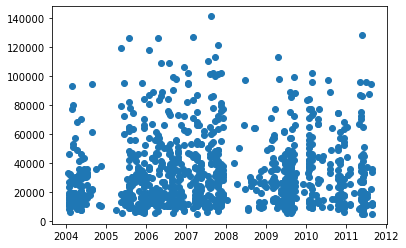

In [10]:
fig, ax = plt.subplots()
ax.scatter(data['saledate'][:1000], data['SalePrice'][:1000])

In [11]:
data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
data.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


### Sort dataframe by saledate

when working with time series data, it is a good thing to sort by date

In [13]:
data.sort_values(by=['saledate'], inplace=True, ascending=True, ignore_index=True)

In [14]:
data.head(20)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN
5,1301884,23500.0,1182999,4123,132,99.0,1976,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
6,1379228,31000.0,1082797,7620,132,99.0,1986,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
7,1645390,11750.0,1527216,8202,132,99.0,1970,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
8,1493279,63000.0,1363756,2759,132,99.0,1987,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
9,1449549,13000.0,1289412,3356,132,99.0,1966,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Make a copy of the original dataframe
 so that we can revert if there are any problems

In [15]:
data_tmp = data.copy()

In [16]:
data_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


# 4. Features

## Feature engineering

### Add datetime parameters of `saledate` column

In [17]:
data_tmp['SaleYear'] = data_tmp.saledate.dt.year
data_tmp['SaleMonth'] = data_tmp.saledate.dt.month
data_tmp['SaleDay'] = data_tmp.saledate.dt.day
data_tmp['SaleDayOfWeek'] = data_tmp.saledate.dt.dayofweek
data_tmp['SaleDayOfYear'] = data_tmp.saledate.dt.dayofyear
data_tmp

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,SaleYear,SaleMonth,SaleDay,SaleDayOfWeek,SaleDayOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,4,28,5,119
412694,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
412695,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
412696,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119


In [18]:
data_tmp.drop('saledate', axis=1, inplace=True)

In [19]:
data_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

# 5. Modelling

model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

model.fit(data_tmp.drop('SalePrice', axis=1), data_tmp.SalePrice)

ValueError as data has non-numeric values and NaN values

### Convert strings to categories

One way to handle string data is to convert them into categories

In [20]:
data_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [21]:
pd.api.types.is_string_dtype(data_tmp['UsageBand'])

True

In [22]:
# Find the columns which contain strings
for label, content in data_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [23]:
# Example of .items()

dicty = {'a': 'first', 'b': 'second'}

for key, value in dicty.items():
    print(f'{key} is the {value} letter in the alphabet')

a is the first letter in the alphabet
b is the second letter in the alphabet


In [24]:
# This will turn all of the string values into category values
for label, content in data_tmp.items():
    if pd.api.types.is_string_dtype(content):
        data_tmp[label] = content.astype('category').cat.as_ordered()

In [25]:
data_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [26]:
data_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [27]:
data_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [28]:
data_tmp.state.cat.codes

0         43
1          8
2          8
3          8
4          8
          ..
412693     4
412694     4
412695     4
412696     4
412697     4
Length: 412698, dtype: int8

In [29]:
data_tmp.isna().sum() / len(data_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### save preprocessed data

In [30]:
data_tmp.to_csv('./data/train_tmp.csv', index=False)

In [31]:
data = pd.read_csv('./data/train_tmp.csv',
                   low_memory=False)
data

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,SaleYear,SaleMonth,SaleDay,SaleDayOfWeek,SaleDayOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,D38E,...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,4,28,5,119
412694,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2064,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
412695,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,337G,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
412696,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,12G,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119


## Filling Missing Values

### Fill numeric data

In [32]:
for label, content in data.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
SaleYear
SaleMonth
SaleDay
SaleDayOfWeek
SaleDayOfYear


In [33]:
# check which numeric values have null values
for label, content in data.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [34]:
# fill numeric rows with the median
for label, content in data.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            data[label+'_is_missing'] = pd.isnull(content)
            data[label] = content.fillna(content.median())

In [35]:
# why median?

hundreds = np.full((1000,), 100)
hundreds_billion = np.append(hundreds, 1000000000)
np.mean(hundreds), np.mean(hundreds_billion), np.median(hundreds), np.median(hundreds_billion)

(100.0, 999100.8991008991, 100.0, 100.0)

you can see how the mean varies for just one outlier

In [36]:
for label, content in data.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

no numeric NaN values

### Filling and turning categorical variables into numbers 

In [37]:
for label, content in data.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [38]:
pd.Categorical(data['state']).codes[:1000]

array([43,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  9,  8,  8,  9,  8,  8,  8,  8,  8,  8,  9,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        9,  8,  8,  8,  8,  8,  8,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8

In [39]:
pd.Categorical(data['state']).isna().sum()

0

In [40]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [41]:
data.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

In [42]:
for label, content in data.items():
    if not pd.api.types.is_numeric_dtype(content):
        # add binary column
        data[label+ '_is_missing'] = pd.isnull(content)
        # Turn categories into number and add +1
        data[label] = pd.Categorical(content).codes + 1

we did +1 as NaN values are encoded as -1

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [45]:
len(data.columns)

103

## Actual Modelling

In [52]:
# model = RandomForestRegressor(n_jobs=-1,
#                               random_state=42)
# model.fit(data.drop('SalePrice', axis=1), data['SalePrice'])

In [53]:
# score the model
# model.score(data.drop('SalePrice', axis=1), data['SalePrice'])

**Questions: Why isn't the above metric reliable?**

**Ans: Because there are no train test splits**

## Splitting data into train/validation sets

In [47]:
data.SaleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: SaleYear, dtype: int64

In [48]:
# split data into training and validation sets

val = data[data.SaleYear == 2012]
train = data[data.SaleYear != 2012]
len(val), len(train)

(11573, 401125)

In [59]:
# Split into X and y

X_train, y_train = train.drop('SalePrice', axis=1), train.SalePrice
X_val, y_val = val.drop('SalePrice', axis=1), val.SalePrice

# 6. Experimentation

## Building an evaluation function (RMSLE)

In [62]:
# Create evaluation function (the compettiton uses RMSLE)
from sklearn.metrics import mean_squared_log_error as msle

def rmsle(y_test, y_preds):
    '''
    Calculates root mean squared log error between preds 
    and true values
    '''
    return np.sqrt(msle(y_test, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
              'Validation MAE': mean_absolute_error(y_val, val_preds),
              'Training MSE': mean_squared_error(y_train, train_preds),
              'Validation MSE': mean_squared_error(y_val,  val_preds),
              'Training RMSLE': rmsle(y_train, train_preds),
              'Validation RMLSE': rmsle(y_val, val_preds),
              'Training R-squared error': r2_score(y_train, train_preds),
              'Validation R-squared error': r2_score(y_val, val_preds)}
    return scores

## Testing our model on a subset (to tune the hyperparameters)

In [57]:
%%time
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples = 10000)

model.fit(X_train, y_train)

Wall time: 23.2 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [63]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Validation MAE': 7177.26365505919,
 'Training MSE': 73944240.61814801,
 'Validation MSE': 115368808.16817886,
 'Training RMSLE': 0.257745378256977,
 'Validation RMLSE': 0.29362638671089003,
 'Training R-squared error': 0.8606658995199189,
 'Validation R-squared error': 0.8320374995090507}

## HyperParameter Tuning with RandomizedSearchCV

In [72]:
%%time

rf_grid = {'n_estimators': np.arange(10, 100, 10),
           'max_depth': [None, 3, 5, 10],
           'min_samples_split': np.arange(2, 20, 2),
           'min_samples_leaf': np.arange(1, 20, 2),
           'max_features': [0.5, 1, 'sqrt', 'auto'],
           'max_samples': [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 2min 26s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [73]:
rs_model.best_params_

{'n_estimators': 70,
 'min_samples_split': 2,
 'min_samples_leaf': 15,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': 10}

In [74]:
# evaluate the model
show_scores(rs_model)

{'Training MAE': 6735.090525824339,
 'Validation MAE': 8209.793913525875,
 'Training MSE': 105790205.5052489,
 'Validation MSE': 154491503.12929803,
 'Training RMSLE': 0.30019073989426703,
 'Validation RMLSE': 0.3262638422763037,
 'Training R-squared error': 0.800658131039632,
 'Validation R-squared error': 0.7750797673806651}

it worsened

### Train a model with the best hyperparameters

**Note:** These hyperparams were the ones found by Daniel after 100 iterations of RandomizedSearchCV

In [75]:
%%time

ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)

ideal_model.fit(X_train, y_train)

Wall time: 2min 17s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1)

In [76]:
show_scores(ideal_model)

{'Training MAE': 2945.9483676846958,
 'Validation MAE': 5964.392328594497,
 'Training MSE': 21653609.934681997,
 'Validation MSE': 81576064.99769168,
 'Training RMSLE': 0.14431938239856648,
 'Validation RMLSE': 0.24648270950318482,
 'Training R-squared error': 0.9591978193680308,
 'Validation R-squared error': 0.8812354909894637}

In [77]:
show_scores(rs_model)

{'Training MAE': 6735.090525824338,
 'Validation MAE': 8209.793913525875,
 'Training MSE': 105790205.5052489,
 'Validation MSE': 154491503.12929803,
 'Training RMSLE': 0.30019073989426703,
 'Validation RMLSE': 0.3262638422763037,
 'Training R-squared error': 0.800658131039632,
 'Validation R-squared error': 0.7750797673806651}

ideal_model rocks

# Make predictions on the Test Data

In [94]:
df_test = pd.read_csv("data/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [95]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

there are strings and NaN values in the test data

## Preprocessing data

In [102]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["SaleYear"] = df.saledate.dt.year
    df["SaleMonth"] = df.saledate.dt.month
    df["SaleDay"] = df.saledate.dt.day
    df["SaleDayOfWeek"] = df.saledate.dt.dayofweek
    df["SaleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df


In [103]:
df_test = preprocess_data(df_test)
df_test.head()

AttributeError: 'DataFrame' object has no attribute 'saledate'

In [105]:
# we can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'SaleDay',
 'SaleDayOfWeek',
 'SaleDayOfYear',
 'SaleMonth',
 'SaleYear',
 'auctioneerID_is_missing'}

everything except for auctioneerID_is_missing, is there, but has a slightly different name

In [107]:
df_test['auctioneerID_is_missing'] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [108]:
preds = ideal_model.predict(df_test)

In [109]:
preds

array([20081.21464337, 20404.02286048, 46780.75516902, ...,
       13939.52537026, 18450.18655209, 32779.64392433])

In [110]:
len(preds)

12457

### Format preds into a df along with SalesID

In [113]:
ans_df = pd.DataFrame()
ans_df['SalesID'] = df_test['SalesID']
ans_df['SalesPrice'] = preds
ans_df

,SalesID,SalesPrice
0,1227829,20081.214643
1,1227844,20404.022860
2,1227847,46780.755169
3,1227848,64053.517476
4,1227863,51920.674286
...,...,...
12452,6643171,43504.705623
12453,6643173,14445.694019
12454,6643184,13939.525370
12455,6643186,18450.186552


In [115]:
ans_df.to_csv('./data/answers.csv', index=False)

## Feature Importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the **target variable** (SalePrice).

In [117]:
importances = ideal_model.feature_importances_
importances

array([3.32126421e-02, 2.08500427e-02, 4.50894006e-02, 2.34962556e-03,
       3.33068248e-03, 2.03436268e-01, 3.46936005e-03, 1.00943702e-03,
       4.24633223e-02, 4.16192581e-02, 6.60613492e-02, 5.00836939e-03,
       2.52694040e-02, 1.56219048e-01, 4.36343879e-02, 5.93234162e-03,
       2.73449071e-03, 3.31514322e-03, 3.77280438e-03, 5.22223435e-02,
       7.08205779e-04, 3.38285390e-05, 1.21528473e-03, 1.57950492e-04,
       1.68171429e-03, 3.07575756e-04, 8.54476450e-04, 1.02661196e-02,
       1.58896296e-04, 1.35819755e-04, 4.45327880e-03, 2.41952549e-03,
       4.09552821e-03, 5.70844084e-04, 2.25978514e-03, 8.77285344e-03,
       8.48976395e-04, 8.35787670e-03, 4.06281296e-04, 1.47085696e-03,
       8.65677426e-04, 8.98157901e-04, 2.67285951e-03, 5.75921150e-04,
       3.35938236e-04, 4.13786823e-04, 1.89540418e-04, 2.21885423e-03,
       8.65357596e-04, 4.40490082e-04, 1.90784140e-04, 7.37124804e-02,
       3.83013651e-03, 5.65564088e-03, 2.94490704e-03, 9.92682371e-03,
      

In [118]:
len(importances)

102

the values == no of columns

In [124]:
def plot_importance(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True)) # Chaining
    
    # Plot the dataframe
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

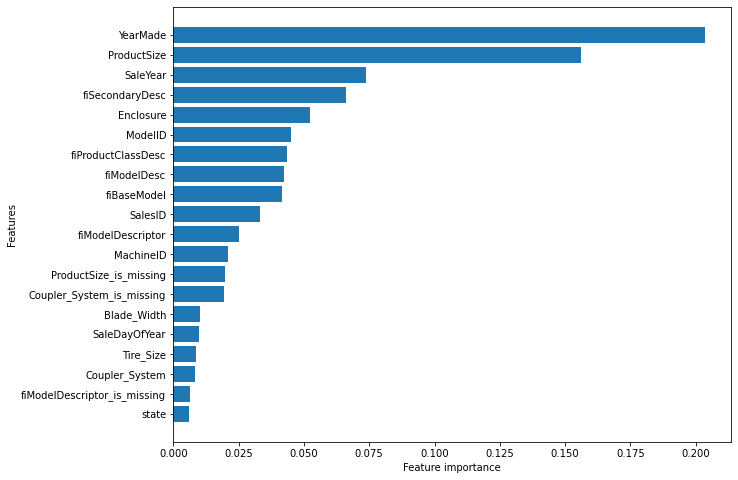

In [125]:
plot_importance(X_train.columns, importances)

### YearMade is the most important feature

In [127]:
df['ProductSize'].value_counts()

Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: ProductSize, dtype: int64

**Question:** How might feature importance help us?


**Answer:** provides an insight on the data and also tells us which features to lose or keep if we have to reduce data